In [1]:
from files.utils.constants import *
from files.utils.utility_functions import *
from files.utils.dataset_creator import *
# from files.pif.base_ransac import *
import torch.nn as nn
import os

ModuleNotFoundError: No module named 'files'

In [ ]:
from files.utils.constants import OLD_INLIERS, NEW_INLIERS, NN, SOM, np, time
from files.utils.utility_functions import *
from files.self_organizing_maps.self_organizing_maps import SelfOrganizingMaps
from files.neural_networks.base_class import AEModel
from files.mss_model import MSSModel
from files.pif.voronoi_iforest import *
from datetime import timedelta


def clustering(pref_m, verbose=0):
    if verbose > 0:
        print('-'*50+"\nClustering of preference matrix")

    num_of_pts = pref_m.shape[0]
    pts = range(num_of_pts)
    clusters = [[i] for i in pts]
    new_idx = pref_m.shape[0]

    pos = {i: i for i in pts}

    x0 = list(itertools.combinations(range(num_of_pts), 2))
    x0 = [(cl_i, cl_j, tanimoto_distance(pref_m[cl_i], pref_m[cl_j]))
          for cl_i, cl_j in x0]

    while pref_m.shape[0] > 1:
        x0.sort(key=lambda y: y[-1])
        cl_0, cl_1, min_distance = x0[0]
        if min_distance >= 1:
            break

        # element-wise min
        new_pf = np.minimum(pref_m[pos[cl_0]], pref_m[pos[cl_1]])
        new_cluster = clusters[pos[cl_0]] + clusters[pos[cl_1]]

        pref_m = np.delete(pref_m, (pos[cl_0], pos[cl_1]), axis=0)
        pref_m = np.vstack((pref_m, new_pf))
        clusters = [c for idx_c, c in enumerate(clusters) if idx_c not in (
            pos[cl_0], pos[cl_1])]  # delete C_i and C_j
        clusters = clusters + [new_cluster]
        new_cluster.sort()

        pos0 = pos[cl_0]
        pos1 = pos[cl_1]
        del pos[cl_0]
        del pos[cl_1]

        for k in pos:
            if pos[k] >= pos0:
                pos[k] -= 1
            if pos[k] >= pos1:
                pos[k] -= 1

        pos[new_idx] = pref_m.shape[0] - 1

        pts = [p for p in pts if p not in (cl_0, cl_1)]
        x0 = [(cl_i, cl_j, d) for cl_i, cl_j, d in x0
              if cl_i not in (cl_0, cl_1) and cl_j not in (cl_0, cl_1)]

        new_comb = [(p, new_idx) for p in pts]
        pts.append(new_idx)
        new_idx += 1
        x1 = [(cl_i, cl_j, tanimoto_distance(pref_m[pos[cl_i]], pref_m[pos[cl_j]]))
              for cl_i, cl_j in new_comb]
        x0 += x1

    return pref_m, clusters


def build_preference_matrix(data, models, verbose=0, images=0):
    if verbose > 0:
        print('-'*50+"\nBuilding preference matrix")
    data = data.copy()

    residuals = np.array([m.get_residuals(data) for m in models.keys()])

    prefs = np.array([[np.exp(-residual[i]/ithr)
                       # if residual[i] < ithr*3 else 0
                       if arr_contains(consensus, p) else 0
                       for i, p in enumerate(data)
                       ]
                      for residual, (consensus, _, ithr) in zip(residuals, models.values())]).T

    preference_matrix = prefs
    idxs_to_eliminate = np.array(
        [i for i, row in enumerate(prefs) if sum(row) == 0])
    if len(idxs_to_eliminate) == 0:
        return prefs, data
    preference_matrix = np.delete(preference_matrix, idxs_to_eliminate, axis=0)
    data = np.delete(data, idxs_to_eliminate, axis=0)

    if images > 1:
        plt.figure(dpi=200)
        plt.imshow(preference_matrix, cmap="Blues")
        plt.colorbar()
        plt.axis("off")
    return preference_matrix, data


LINE = "Line"
CIRCLE = "Circle"
MIXED = "Mixed"

class BaseEstimator:

    def __init__(self, class_type):
        self.class_type = class_type

    def fit(self, mss):
        pass

    def get_inliers(self, data, in_th=1, v=None):
        pass

class LineEstimator(BaseEstimator):

    def __init__(self):
        super(LineEstimator, self).__init__(class_type=LINE)
        self.slope = np.inf
        self.intercept = np.inf

    def fit(self, mss):
        assert len(mss) == 2
        p1, p2 = mss
        self.slope = (p1[1] - p2[1]) / (p1[0] - p2[0])
        self.intercept = -self.slope*p1[0] + p1[1]
        return self

    def get_residuals(self, data):
        # residuals: distance of each point from the rect
        return np.array([
            np.abs(p[1] - (self.slope * p[0] + self.intercept)) / (np.sqrt(1 + self.slope**2))
            for p in data
        ])

    def get_inliers(self, data, in_th=1, v=None):
        residuals = self.get_residuals(data)
        return data[residuals**2 < in_th**2]

class CircleEstimator(BaseEstimator):

    def __init__(self):
        super(CircleEstimator, self).__init__(class_type=CIRCLE)
        self.center = (np.inf, np.inf)
        self.radius = np.inf

    # Fonte: https://math.stackexchange.com/questions/213658/get-the-equation-of-a-circle-when-given-3-points
    def fit(self, mss):
        assert len(mss) == 3

        matrix = np.zeros(shape=(3, 4))
        for i, p in enumerate(mss):
            x, y = p
            matrix[i, 0] = x**2 + y**2
            matrix[i, 1] = x
            matrix[i, 2] = y
            matrix[i, 3] = 1
        M11 = np.linalg.det(np.delete(matrix, 0, axis=1))
        M12 = np.linalg.det(np.delete(matrix, 1, axis=1))
        M13 = np.linalg.det(np.delete(matrix, 2, axis=1))
        M14 = np.linalg.det(np.delete(matrix, 3, axis=1))

        x0 = 0.5 * M12 / M11
        y0 = - 0.5 * M13 / M11

        self.center = (x0, y0)
        self.radius = np.sqrt(x0**2 + y0**2 + M14 / M11)

        return self

    def get_residuals(self, data):
        # residuals: distance of each point from the rect
        return np.array([
            np.abs(euclidean_distance(p, self.center) - self.radius)
            for p in data
        ])

    def get_inliers(self, data, in_th=1, v=None):
        # residuals: distance of each point from the rect
        residuals = self.get_residuals(data)
        return data[residuals**2 < in_th**2]

class BaseRansac:

    def __init__(self, data, model_name, in_th=None, verbose=1, images=0, v=NEW_INLIERS):
        self.original_data = data.copy()
        self.new_data = data.copy()
        self.model_name = model_name
        self.n_dimensions = data.shape[-1]
        if in_th is None:
            self.in_ths = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1]
        else:
            self.in_ths = in_th
        self.verbose = verbose
        self.images = images
        self.v = v
        self.models = None
        self.preference_matrix = None

    def ransac(self, k_max=30, delete=False):
        if self.verbose > 0:
            print('-'*50+"\nBuilding RanSac models")
        models = {}
        k = 0
        it = 0
        best_consensus_len = 0

        chars_to_print = 30
        start_time = time.monotonic()

        sampling_data = self.new_data.copy()
        mss = 2 if self.model_name == LINE else 3

        while it < k_max and len(sampling_data) >= mss:
            it += 1
            try:
                sampled_ds_idxs = localized_sampling(sampling_data, mss)
                sampled_ds = sampling_data[sampled_ds_idxs]
            except Exception as ex:
                print(traceback.format_exc())
                print(ex)
                break

            if self.model_name == LINE:
                model = LineEstimator()
            elif self.model_name == CIRCLE:
                model = CircleEstimator()
            elif self.model_name == MIXED:
                if np.random.uniform() < 0.5:
                    model = LineEstimator()
                else:
                    model = CircleEstimator()

            model.fit(mss=sampled_ds)

            if isinstance(self.in_ths, list) or isinstance(self.in_ths, np.ndarray):
                ithr = self.in_ths[np.random.randint(0, len(self.in_ths))]
            else:
                ithr = self.in_ths
            consensus = model.get_inliers(sampling_data, in_th=ithr, v=self.v)

            if delete:
                # delete from sampling data all the points of the consensus set
                sampling_data = sampling_data[np.all(
                    np.any((sampling_data-consensus[:, None]), axis=2), axis=0)]

            if len(consensus) > best_consensus_len:
                best_consensus_len = len(consensus)
            models[model] = (consensus, sampled_ds, ithr)

            if self.verbose > 0:
                perc = int(it / k_max * chars_to_print)
                dt = timedelta(seconds=time.monotonic() - start_time)
                sys.stdout.write(f"\rIteration {it}/{k_max}: [" + "="*perc + ">" + "."*(
                    chars_to_print-perc) + f"] ({int(it/k_max*100)}%) ETA: {dt} Len best cons: {best_consensus_len}")
                sys.stdout.flush()
        if self.verbose > 0:
            dt = timedelta(seconds=time.monotonic()-start_time)
            print(f"\rIteration {k_max}/{k_max}: [" + "="*chars_to_print +
                  f"] (100%) ETA: {dt} Len best cons: {best_consensus_len}")

        # sort models depending on consensus size
        # models = dict(sorted(models.items(), key=lambda item: len(item[1]), reverse=True))

        self.models = models
        return models

    def t_linkage(self, k_max=30, n_models=-1, sort_clusters=True,
                  delete=False):
        if self.verbose > 0:
            print("T-Linkage")
        if self.models is None:
            self.ransac(k_max, delete=delete)
        else:
            if self.verbose > 0:
                print('-'*50+"\nNot building models Pool because already generated.")
        if self.preference_matrix is None:
            self.preference_matrix, self.new_data = build_preference_matrix(
                data=self.new_data, models=self.models, verbose=self.verbose, images=self.images)
        else:
            if self.verbose > 0:
                print('-'*50+"\nNot building Preference Matrix because already generated.")
        new_preferences, clusters = clustering(
            self.preference_matrix, verbose=self.verbose)

        if self.verbose > 0:
            print('-'*50+"\nDone")
        if sort_clusters:
            clusters.sort(key=lambda c: -len(c))

        self.new_data_to_original = {i: j for j, p2 in enumerate(
            self.original_data) for i, p in enumerate(self.new_data) if np.all(p == p2)}

        new_clusters = np.zeros(len(self.original_data))
        for i, cl in enumerate(clusters[:n_models]):
            for j, p in enumerate(cl):
                clusters[i][j] = self.new_data_to_original[p]
            new_clusters[cl] = i+1
        new_clusters = new_clusters.astype(int)

        if self.images > 0:
            plot_clusters(clusters, self.original_data)

        return new_preferences, new_clusters

    def anomaly_detection(self, k_max=30, delete=False):
        if self.verbose > 0: print("Anomaly Detection")
        if self.models is None:
            self.ransac(k_max, delete=delete)
        else:
            if self.verbose > 0:
                print('-'*50+"\nNot building models Pool because already generated.")
        if self.preference_matrix is None:
            self.preference_matrix, self.new_data = build_preference_matrix(
                data=self.new_data, models=self.models, verbose=self.verbose, images=self.images)
        else:
            if self.verbose > 0:
                print('-'*50+"\nNot building Preference Matrix because already generated.")

        diff_len = len(self.original_data) - len(self.new_data)
        self.preference_matrix = np.append(self.preference_matrix, np.zeros(
            shape=(diff_len, self.preference_matrix.shape[1])), axis=0)

        if self.verbose > 0:
            print('-'*50+"\nBuilding Voronoi Forest")
        ivor_parameters: dict = {'num_trees': 100, 'max_samples': 256, 'branching_factor': 2, 'metric': 'tanimoto',
                                 'n_jobs': -1}
        voronoi = VoronoiIForest(**ivor_parameters)
        voronoi.fit(self.preference_matrix)
        scores = voronoi.score_samples(self.preference_matrix)
        if self.verbose > 0:
            print('-'*50+"\nDone")
        return scores

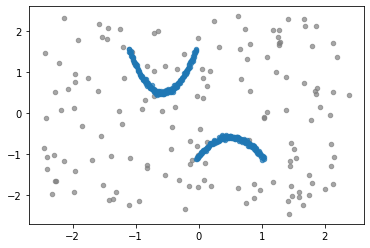

In [ ]:
# ds, gt = create_dataset_line(500, m_s=[1, -0.5], centers=[(-2,2), (2,-2)], outliers_fraction=0.3)
ds, gt = create_dataset_parabola(500, a_s=[1, -0.5], centers=[(-2,2), (2,-2)], outliers_fraction=0.3)
ds = normalize_points(ds)
gt[gt>1] = 1
plot(ds[gt==0], c='gray')
plot(ds[gt!=0])

(None, (500, 2))

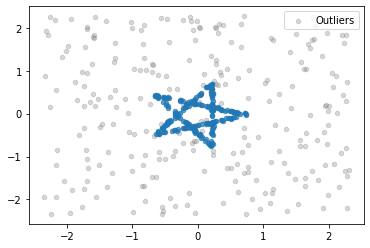

In [ ]:
base_path = joinpath("..", "..", "datasets", "2d", "lines")

content = None
with open(joinpath(base_path, "star5.csv")) as f:
    content = f.read().split("\n")
    content = np.array([[float(s) for s in c.split(",")] for c in content if c != ""]).astype(float).T
with open(joinpath(base_path, "star5_gt.csv")) as f:
    gt = np.array([int(s)  for l in f.read().split("\n") for s in l if l != ""])
    gt[gt > 1] = 1

of = 1
outliers = np.random.uniform(-3, 3, size=(int(len(content)*of), 2))
gt = np.append(gt, [0 for _ in outliers])
ds = np.vstack((content, outliers))


# ds, gt = create_dataset_parabola(500, a_s=[1, -1], centers=[(2, 2), (-2, -2)], rot_angle=[0, 90], outliers_fraction=0.2)

ds = normalize_points(ds)

idxs = np.arange(len(ds))
np.random.shuffle(idxs)
ds = ds[idxs]
gt = gt[idxs]

plot(ds[gt == 0], c='gray', alpha=0.3, label="Outliers")
plot(ds[gt != 0]), ds.shape

In [ ]:
sac = BaseRansac(ds, LINE)
prefs, cluss = sac.t_linkage(k_max=500, n_models=5)

scores = sac.anomaly_detection()

T-Linkage
--------------------------------------------------
Building RanSac models
Iteration 500/500: [==============================] (100%) ETA: 0:00:01.741101 Len best cons: 3833
--------------------------------------------------
Building preference matrix
--------------------------------------------------
Clustering of preference matrix
--------------------------------------------------
Done
Anomaly Detection
--------------------------------------------------
Not building models Pool because already generated.
--------------------------------------------------
Not building Preference Matrix because already generated.
--------------------------------------------------
Building Voronoi Forest
--------------------------------------------------
Done


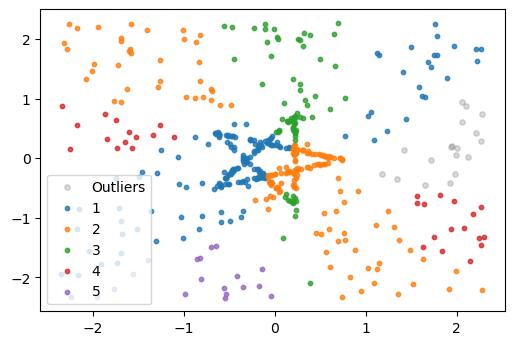

In [ ]:
plot_clusters(cluss, ds)

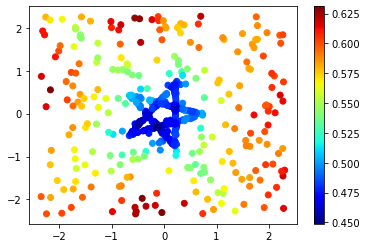

In [ ]:
plt.scatter(ds[:,0], ds[:,1], c=scores, cmap="jet")
plt.colorbar()

In [ ]:
np.median(scores), np.mean(scores)

(0.5006590120729979, 0.5230454970385631)

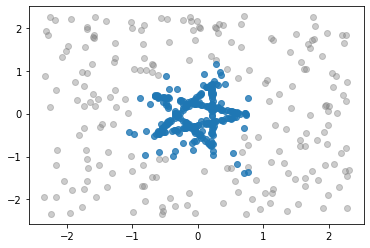

In [ ]:
mask = scores < 0.54#np.median(scores)# - 1.48*mad(scores)# np.median(scores)
inls = ds[mask]
outs = ds[~mask]
plt.scatter(outs[:,0], outs[:,1], c='gray', alpha=0.4)
plt.scatter(inls[:,0], inls[:,1], alpha=0.8)